# **Cyclists feature engineering**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import os

os.chdir(os.path.dirname(os.getcwd()))      # Move to parent directory


In [3]:
print(os.getcwd())

cyclists_df = pd.read_csv('dataset/cleaned_cyclists.csv')
races_df = pd.read_csv('dataset/cleaned_races.csv')

/Users/francesco/Desktop/unipi/MAGISTRALE/2_ANNO/data_mining/dm-2425


In [4]:
cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094 entries, 0 to 6093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _url         6094 non-null   object
 1   name         6094 non-null   object
 2   birth_year   6094 non-null   int64 
 3   nationality  6094 non-null   object
dtypes: int64(1), object(3)
memory usage: 190.6+ KB


#### ```cyclist_experience``` column

Count how many stages the cyclist partecipate as an overall experience

In [5]:
# Group by cyclist and count the number of stages each cyclist participated in 
# Note: aassuming no duplicates in same stage
stages_participated = races_df.groupby('cyclist').size().reset_index(name='cyclist_experience')

# Rename 'cyclist' in stages_participated to avoid conflicts
stages_participated = stages_participated.rename(columns={'cyclist': 'cyclist_id'})

# Merge the stages_participated with cyclists_df to add the 'cyclist_experience' column
# Specify suffixes to avoid duplicate columns
cyclists_df = cyclists_df.merge(stages_participated, left_on='_url', right_on='cyclist_id', how='left')

# Drop the redundant 'cyclist_id' column from the merged DataFrame
cyclists_df = cyclists_df.drop(columns=['cyclist_id'])

# Replace NaN values in cyclist_experience with 0 (for cyclists with no participation records)
cyclists_df['cyclist_experience'] = cyclists_df['cyclist_experience'].fillna(0).astype(int)

# Check the output
print(cyclists_df[["_url", "cyclist_experience"]].head(3))

# Verify correctness of the computation (sum of cyclist_experience should match number of rows in races_df)
print("Total cyclist_experience:", cyclists_df['cyclist_experience'].sum())


          _url  cyclist_experience
0  bruno-surra                   1
1   gerard-rue                 222
2     jan-maas                  49
Total cyclist_experience: 589616


The sum is correct as we have as many entries as the rows in the dataset

In [6]:
print(f"Null values in cyclist_experience column: {int(cyclists_df['cyclist_experience'].isnull().sum())}")

Null values in cyclist_experience column: 0


In [7]:
cyclists_df['cyclist_experience'].describe()

count    6094.000000
mean       96.753528
std       140.776051
min         1.000000
25%         5.000000
50%        30.000000
75%       133.000000
max       959.000000
Name: cyclist_experience, dtype: float64

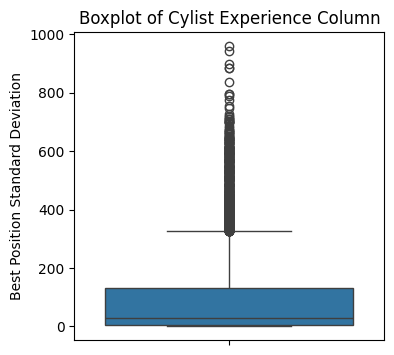

In [8]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='cyclist_experience', data=cyclists_df)
plt.title('Boxplot of Cylist Experience Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

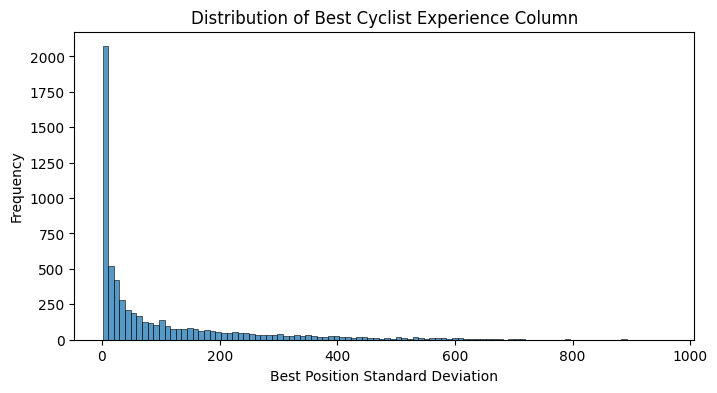

In [9]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_experience'], bins=100)
plt.title('Distribution of Best Cyclist Experience Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

In [10]:
threshold = 8

less_than_15_experience = (cyclists_df['cyclist_experience'] < threshold).sum()
print(f"Number of cyclists with less than {threshold} experience: {less_than_15_experience}")

Number of cyclists with less than 8 experience: 1783


Since many cyclists in this dataset have participated in very few stages, we have decided to exclude them. Our analysis focuses on professional cyclists, and we want to avoid the influence of non-professional cyclists (those with very few races) on our results. This exclusion will also improve the distribution of the following engineered features.

In [11]:
# Drop cyclists where experience is less than the threshold
cyclists_df = cyclists_df[cyclists_df['cyclist_experience'] >= threshold]

# Verify the result
print(f"Number of cyclists after dropping those with experience less than {threshold}: {len(cyclists_df)}")

Number of cyclists after dropping those with experience less than 8: 4311


Revamped analysis after the cleaning

In [12]:
cyclists_df['cyclist_experience'].describe()

count    4311.000000
mean      135.613547
std       151.169641
min         8.000000
25%        26.000000
50%        74.000000
75%       192.000000
max       959.000000
Name: cyclist_experience, dtype: float64

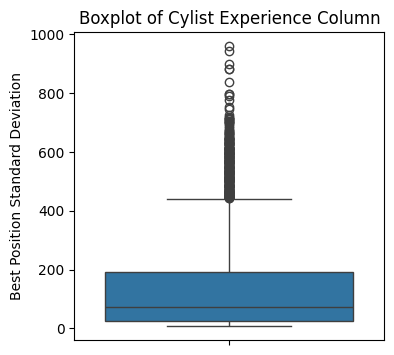

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='cyclist_experience', data=cyclists_df)
plt.title('Boxplot of Cylist Experience Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

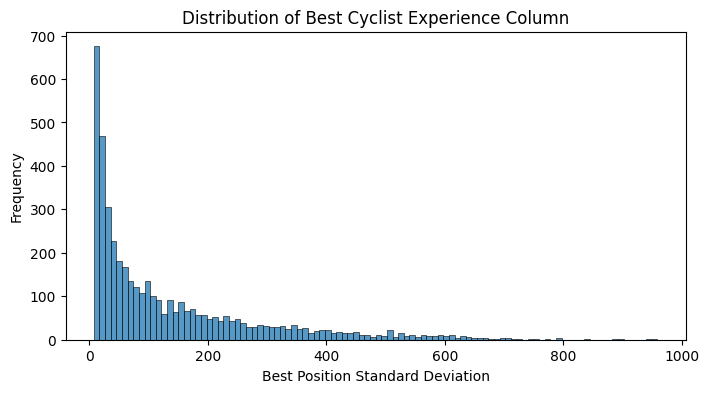

In [14]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_experience'], bins=100)
plt.title('Distribution of Best Cyclist Experience Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

#### ```experience_cat``` column

In [15]:
# Define the bins and labels
bins = [0, 26, 74, 192, 959]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Expert']

# Create a new column 'experience_category' based on the bins
cyclists_df['experience_cat'] = pd.cut(cyclists_df['cyclist_experience'], bins=bins, labels=labels, include_lowest=True)

# Display the first few rows to verify
cyclists_df.value_counts('experience_cat')

experience_cat
Beginner        1105
Advanced        1078
Expert          1073
Intermediate    1055
Name: count, dtype: int64

#### ```continent``` column

Continent column is created to reduce number of classes of nationality. If clusters capture nationality informations this column could be useful

In [16]:
# Function to convert country name to continent
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# Apply the function to create a new column 'continent'
cyclists_df['continent'] = cyclists_df['nationality'].apply(country_to_continent)

# Display the first few rows to verify
print(cyclists_df[['nationality', 'continent']].head(10))

      nationality      continent
1          France         Europe
2     Netherlands         Europe
3         Belgium         Europe
4           Spain         Europe
7   United States  North America
8     Netherlands         Europe
9   Great Britain         Europe
11          Spain         Europe
12          Italy         Europe
15         France         Europe


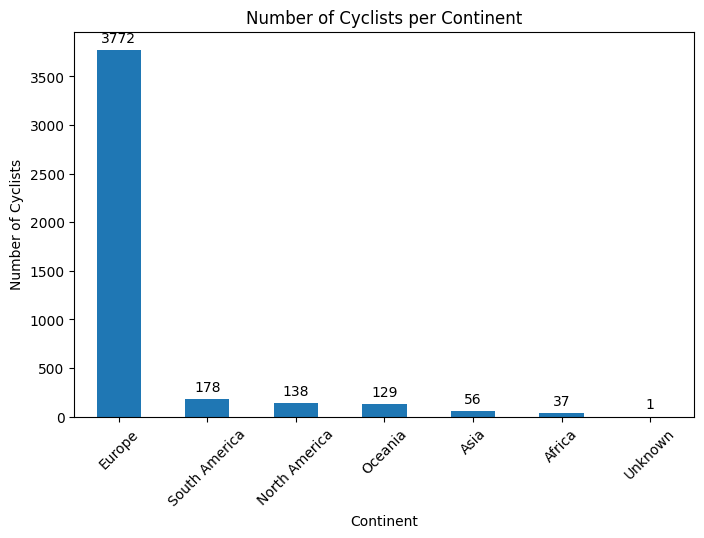

In [17]:
# Count the number of cyclists per continent
continent_counts = cyclists_df['continent'].value_counts()

# Plot the number of cyclists per continent as a histogram
plt.figure(figsize=(8, 5))
ax = continent_counts.plot(kind='bar')
plt.title('Number of Cyclists per Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=45)

# Add the count above each bin
for i, count in enumerate(continent_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom')

plt.show()

The problem with this column is that the most cyclists belong to European continent, so its very unbalanced.

Given that majority of cyclists are european let's deep into european cyclist analysis

In [18]:
# Filter cyclists by European continent
european_df = cyclists_df[cyclists_df['continent'] == 'Europe'].drop(columns=['continent'])

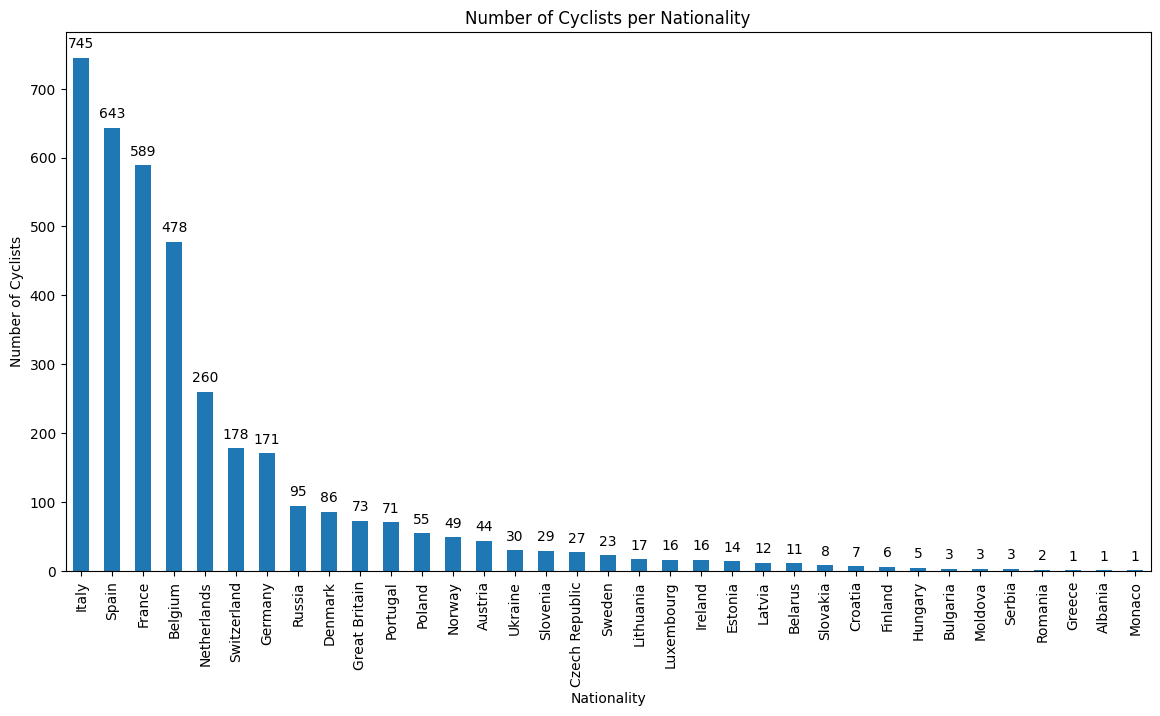

In [19]:
# Count the number of cyclists per nationality
nationality_counts = european_df['nationality'].value_counts()

# Plot the number of cyclists per nationality as a histogram
plt.figure(figsize=(14, 7))
ax = nationality_counts.plot(kind='bar')
plt.title('Number of Cyclists per Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=90)

# Add the count above each bin
for i, count in enumerate(nationality_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

#### ```cyclist_win``` column

Count how many stages won each cyclist

In [20]:
# Group by cyclist and count the number of times position is 0
stages_won = races_df[races_df['position'] == 0].groupby('cyclist').size().reset_index(name='position')

# Add cyclists who never had position 0 with counter set to 0
all_cyclists = pd.DataFrame(races_df['cyclist'].unique(), columns=['cyclist'])
stages_won_df = pd.merge(all_cyclists, stages_won, on='cyclist', how='left').fillna(0)

# Ensure position is an integer
stages_won_df['position'] = stages_won_df['position'].astype(int)
# Merge the stages_won_df with cyclists_df to add the 'cyclist_win' column
cyclists_df = cyclists_df.merge(stages_won_df, left_on='_url', right_on='cyclist', how='left')

# Rename the 'position' column to 'cyclist_win'
cyclists_df = cyclists_df.rename(columns={'position': 'cyclist_win'})

# Drop the redundant 'cyclist' column
cyclists_df = cyclists_df.drop(columns=['cyclist'])

print(cyclists_df[["_url", "cyclist_win"]].head(3))

#check correctness of the computation (sum(races won) = num. of races)
print("Total cyclist_wins:", cyclists_df['cyclist_win'].sum())


                   _url  cyclist_win
0            gerard-rue            3
1              jan-maas            0
2  nathan-van-hooydonck            0
Total cyclist_wins: 5235


Some useful analysis on win column like max, min, counting...

In [21]:
cyclists_df['cyclist_win'].describe()

count    4311.000000
mean        1.214335
std         4.270167
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        92.000000
Name: cyclist_win, dtype: float64

Plot distribution of stages won

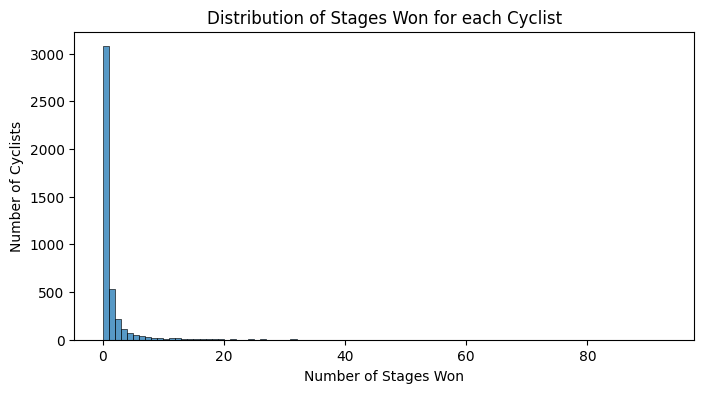

In [22]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_win'], bins=range(0, int(cyclists_df['cyclist_win'].max()) + 2), kde=False)
plt.title('Distribution of Stages Won for each Cyclist')
plt.xlabel('Number of Stages Won')
plt.ylabel('Number of Cyclists')
plt.show()

#### ```carreer_level``` column in cyclists_df

cyclist's carreer level is calculated by considering all the stages partecipated. 
The carreer level of the cyclis is computed as follows: 
$$
V = \frac{1}{T} \sum_{i=1}^{4} \left( N_i \cdot W_i \cdot P_i \right)
$$

In [23]:
# Sort the `races_df` DataFrame by the '_url' and 'start_date' columns 
races_df = races_df.sort_values(by=['_url', 'start_date'], kind='mergesort')  

**position weigth**

In [24]:
from utils import compute_cyclist_performance

WEIGHTS = {
    'win_points': 1.0,              # Weight for wins
    'second_place_points': 0.85,    # Weight for second places
    'third_place_points': 0.80,     # Weight for third places
    'fourth_place_points': 0.75,    # Weight for fourth places
}

cyclist_performance = compute_cyclist_performance(races_df, WEIGHTS)

In [ ]:

# add a carreer_level column to the cyclists_df
cyclists_df['carreer_level'] = 0.0

arr = ['win_points', 'second_place_points', 'third_place_points', 'fourth_place_points', 'total_races']

for cyclist, races in cyclist_performance.items():
        placement_sum = 0

        win_points = cyclist_performance[cyclist]['win_points']
        second_points = cyclist_performance[cyclist]['second_place_points']
        third_points = cyclist_performance[cyclist]['third_place_points']
        fourth_points = cyclist_performance[cyclist]['fourth_place_points']
        total_races = cyclist_performance[cyclist]['total_races']

        for points in win_points:
            placement_sum += WEIGHTS['win_points'] * points
        for points in second_points:
            placement_sum += WEIGHTS['second_place_points'] * points
        for points in third_points:
            placement_sum += WEIGHTS['third_place_points'] * points
        for points in fourth_points:
            placement_sum += WEIGHTS['fourth_place_points'] * points
        
        normalized_level = placement_sum+total_races

        # Update the 'carreer_level' in the cyclist_df
        cyclists_df.loc[cyclists_df['_url'] == cyclist, 'carreer_level'] = normalized_level

##### Revamped analysis

In [ ]:
cyclists_df['carreer_level'].describe()

count     4311.000000
mean       504.594792
std       1160.254330
min          8.000000
25%         32.000000
50%        136.000000
75%        467.500000
max      19751.000000
Name: carreer_level, dtype: float64

In [ ]:
print(cyclists_df[cyclists_df['carreer_level'] < 5][['_url', 'carreer_level']])

Empty DataFrame
Columns: [_url, carreer_level]
Index: []


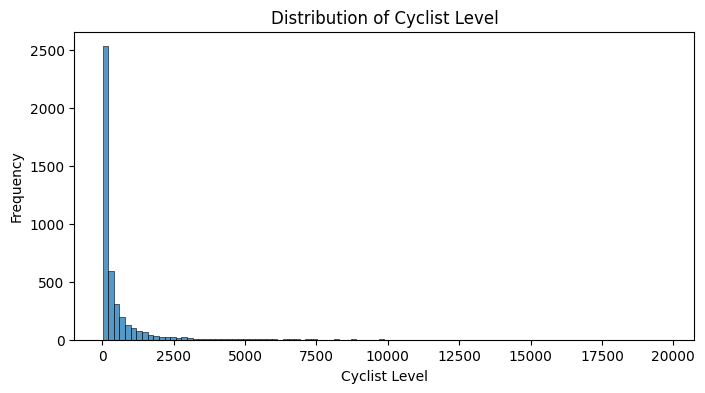

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['carreer_level'], bins=100)
plt.title('Distribution of Cyclist Level')
plt.xlabel('Cyclist Level')
plt.ylabel('Frequency')
plt.show()

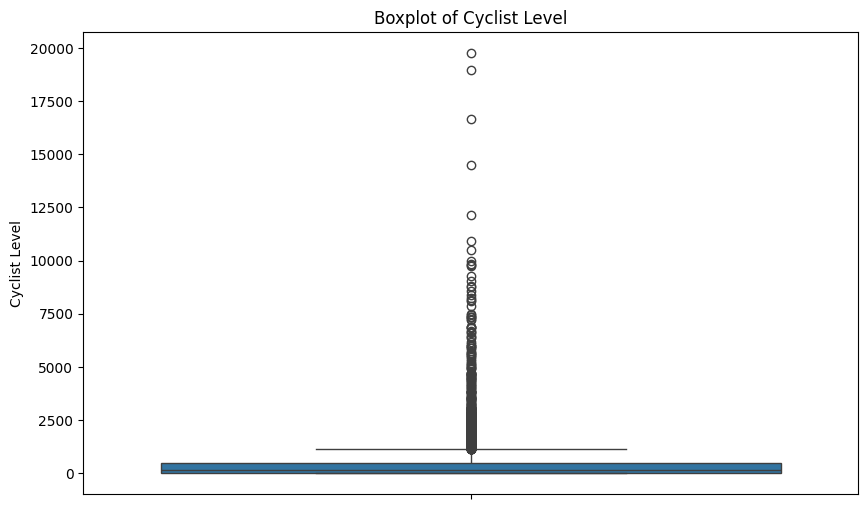

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='carreer_level', data=cyclists_df)
plt.title('Boxplot of Cyclist Level')
plt.ylabel('Cyclist Level')
plt.show()

#### ```best_position``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [ ]:
best_finish_position = races_df.groupby('cyclist')['position'].min().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

In [ ]:
print(f"Null values in best_position column: {int(cyclists_df['best_position'].isnull().sum())}")

Null values in best_position column: 0


In [ ]:
cyclists_df['best_position'].describe()

count    4311.000000
mean       10.918348
std        18.311682
min         0.000000
25%         0.000000
50%         3.000000
75%        13.000000
max       149.000000
Name: best_position, dtype: float64

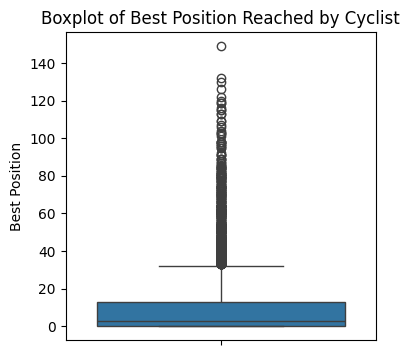

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position', data=cyclists_df)
plt.title('Boxplot of Best Position Reached by Cyclist')
plt.ylabel('Best Position')
plt.show()

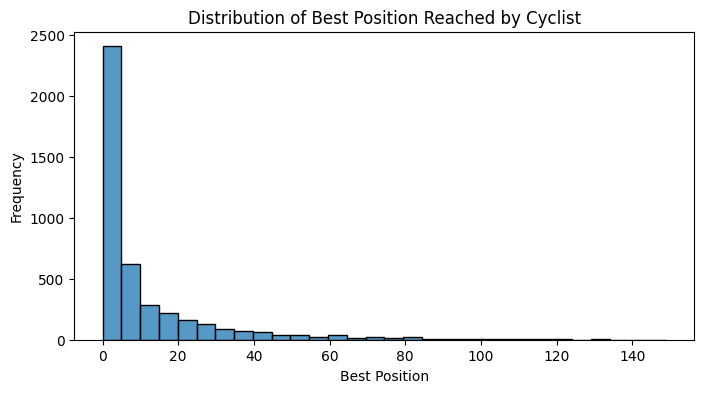

In [ ]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position'], bins=30)
plt.title('Distribution of Best Position Reached by Cyclist')
plt.xlabel('Best Position')
plt.ylabel('Frequency')
plt.show()

Checking the number of races in which cyclists who have never finished above 100th position have participated, with the assumption that these are cyclists with participation limited to a few stages or a single stage.

In [ ]:
# Filter cyclists who have never finished above 150th position
cyclists_never_above_150 = cyclists_df[cyclists_df['best_position'] > 100]['_url']

# Filter races_df to include only these cyclists
races_never_above_150 = races_df[races_df['cyclist'].isin(cyclists_never_above_150)]

# Count the number of stages each of these cyclists has participated in
# NOTE: at this point no cyclist has a duplicated entry in the same stage
races_count_never_above_150 = races_never_above_150['cyclist'].value_counts()

# Merge the counts with the best positions
races_count_with_best_position = races_count_never_above_150.to_frame().merge(
    cyclists_df, left_index=True, right_on='_url',
).rename(columns={'_url': 'cyclist name', 'count': 'Number of Stages', 'best_position': 'Best Position'})

# Display the result
print(races_count_with_best_position[['cyclist name', 'Number of Stages', 'Best Position']])

                    cyclist name  Number of Stages  Best Position
624                sho-hatsuyama                36            115
4151             giuliano-biatta                21            102
3235       hector-manuel-castano                16            103
2013             andoni-lafuente                15            120
3960            sebastian-lander                12            130
2052         patrick-schoovaerts                11            116
2952           benedito-ferreira                11            106
401                  ivan-santos                11            107
867                david-vitoria                11            113
876           ricardo-felgueiras                10            113
4176          bernhard-rassinger                10            126
1557                  dylan-page                 9            104
3798                 jose-amador                 9            109
426         joaquin-novoa-mendez                 9            122
2138      

As expected, these cyclists will take part in very few stages so they probably are not so strong

#### ```best_position_std``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [ ]:
best_finish_position = races_df.groupby('cyclist')['position'].std().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position_std'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

In [ ]:
print(f"Null values in best_position_std column: {int(cyclists_df['best_position_std'].isnull().sum())}")

Null values in best_position_std column: 0


When the cyclist attends only one stage, the standard deviation is zero, so we replace it with 0 which should be intended as no standard deviation.

In [ ]:
cyclists_df.fillna({'best_position_std':0}, inplace=True)

# Verify if the operation was successful
print(f"Null values in best_position_std column: {int(cyclists_df['best_position_std'].isnull().sum())}")

Null values in best_position_std column: 0


In [ ]:
cyclists_df['best_position_std'].describe()

count    4311.000000
mean       40.148052
std        10.715862
min         4.004405
25%        34.363717
50%        40.491808
75%        46.641359
max        89.777403
Name: best_position_std, dtype: float64

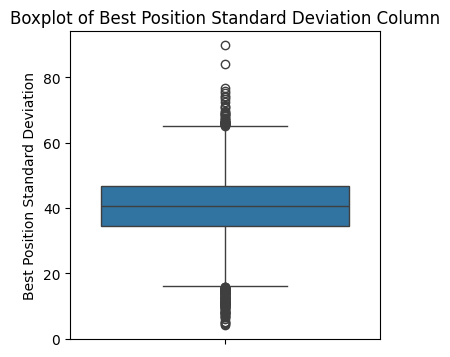

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position_std', data=cyclists_df)
plt.title('Boxplot of Best Position Standard Deviation Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

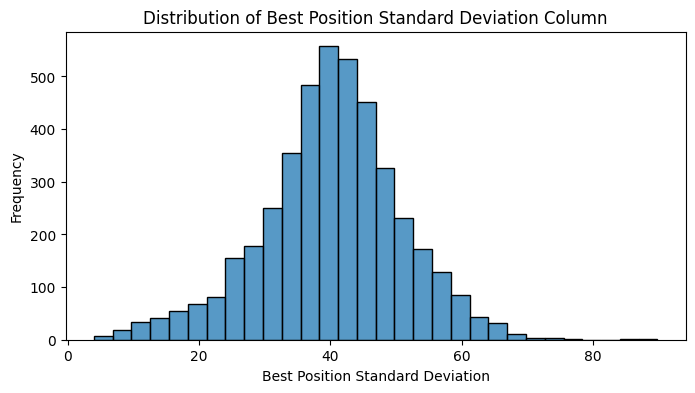

In [ ]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position_std'], bins=30)
plt.title('Distribution of Best Position Standard Deviation Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

TODO: comment what this results means, why high std? this probably means inconsistency trought time or similar things

---

#### Remaining Columns

In [ ]:
cyclists_df.drop(columns=['cyclist_x', 'cyclist_y' ], inplace=True)
cyclists_df.columns.to_list()

['_url',
 'name',
 'birth_year',
 'nationality',
 'cyclist_experience',
 'experience_cat',
 'continent',
 'cyclist_win',
 'carreer_level',
 'best_position',
 'best_position_std']

#### Scatter Plots

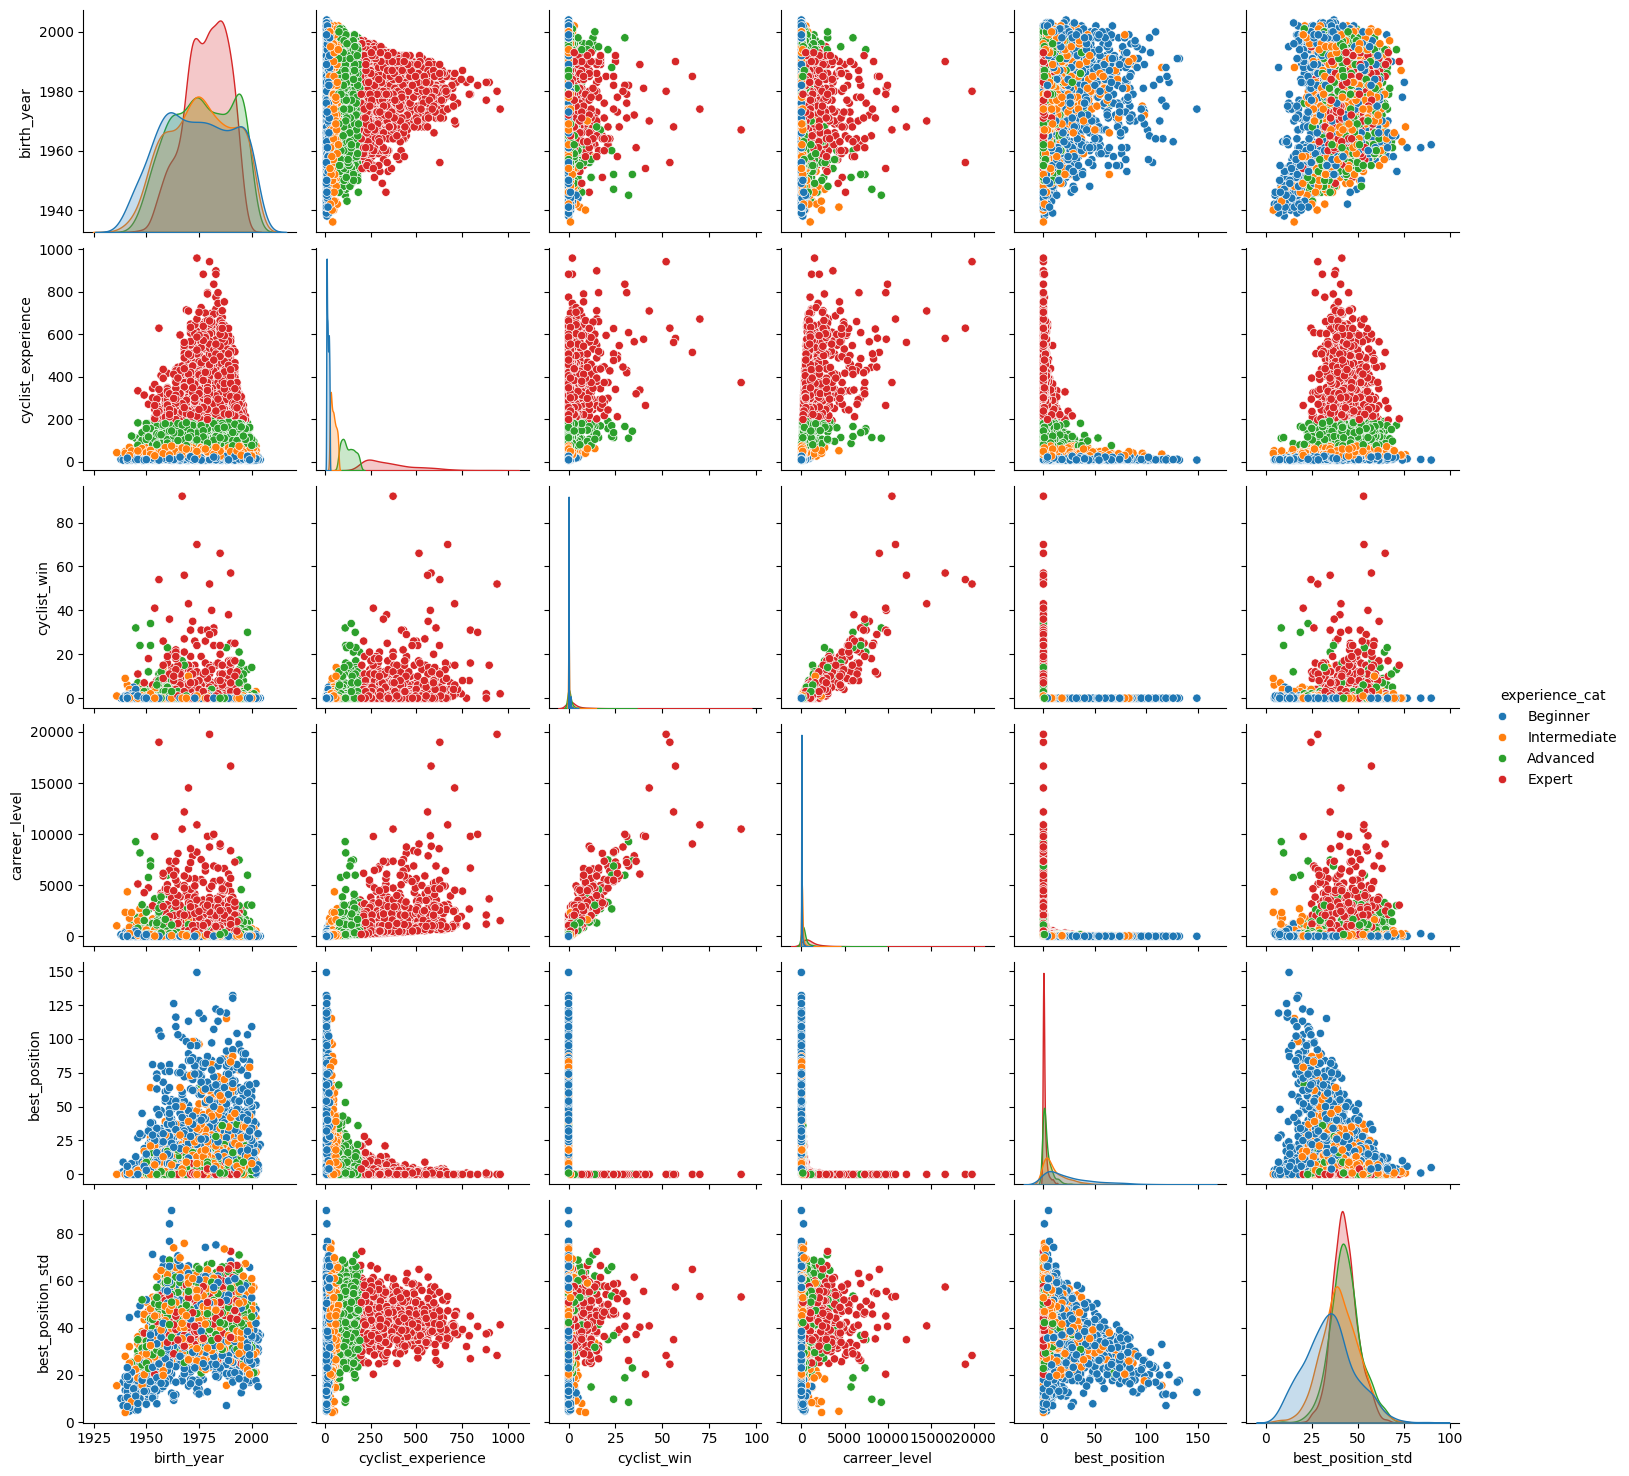

In [ ]:
sns.pairplot(cyclists_df, hue='experience_cat')
plt.show()

We filter out only first nationality as they are the most represented to do a scatter plot basing on nationality

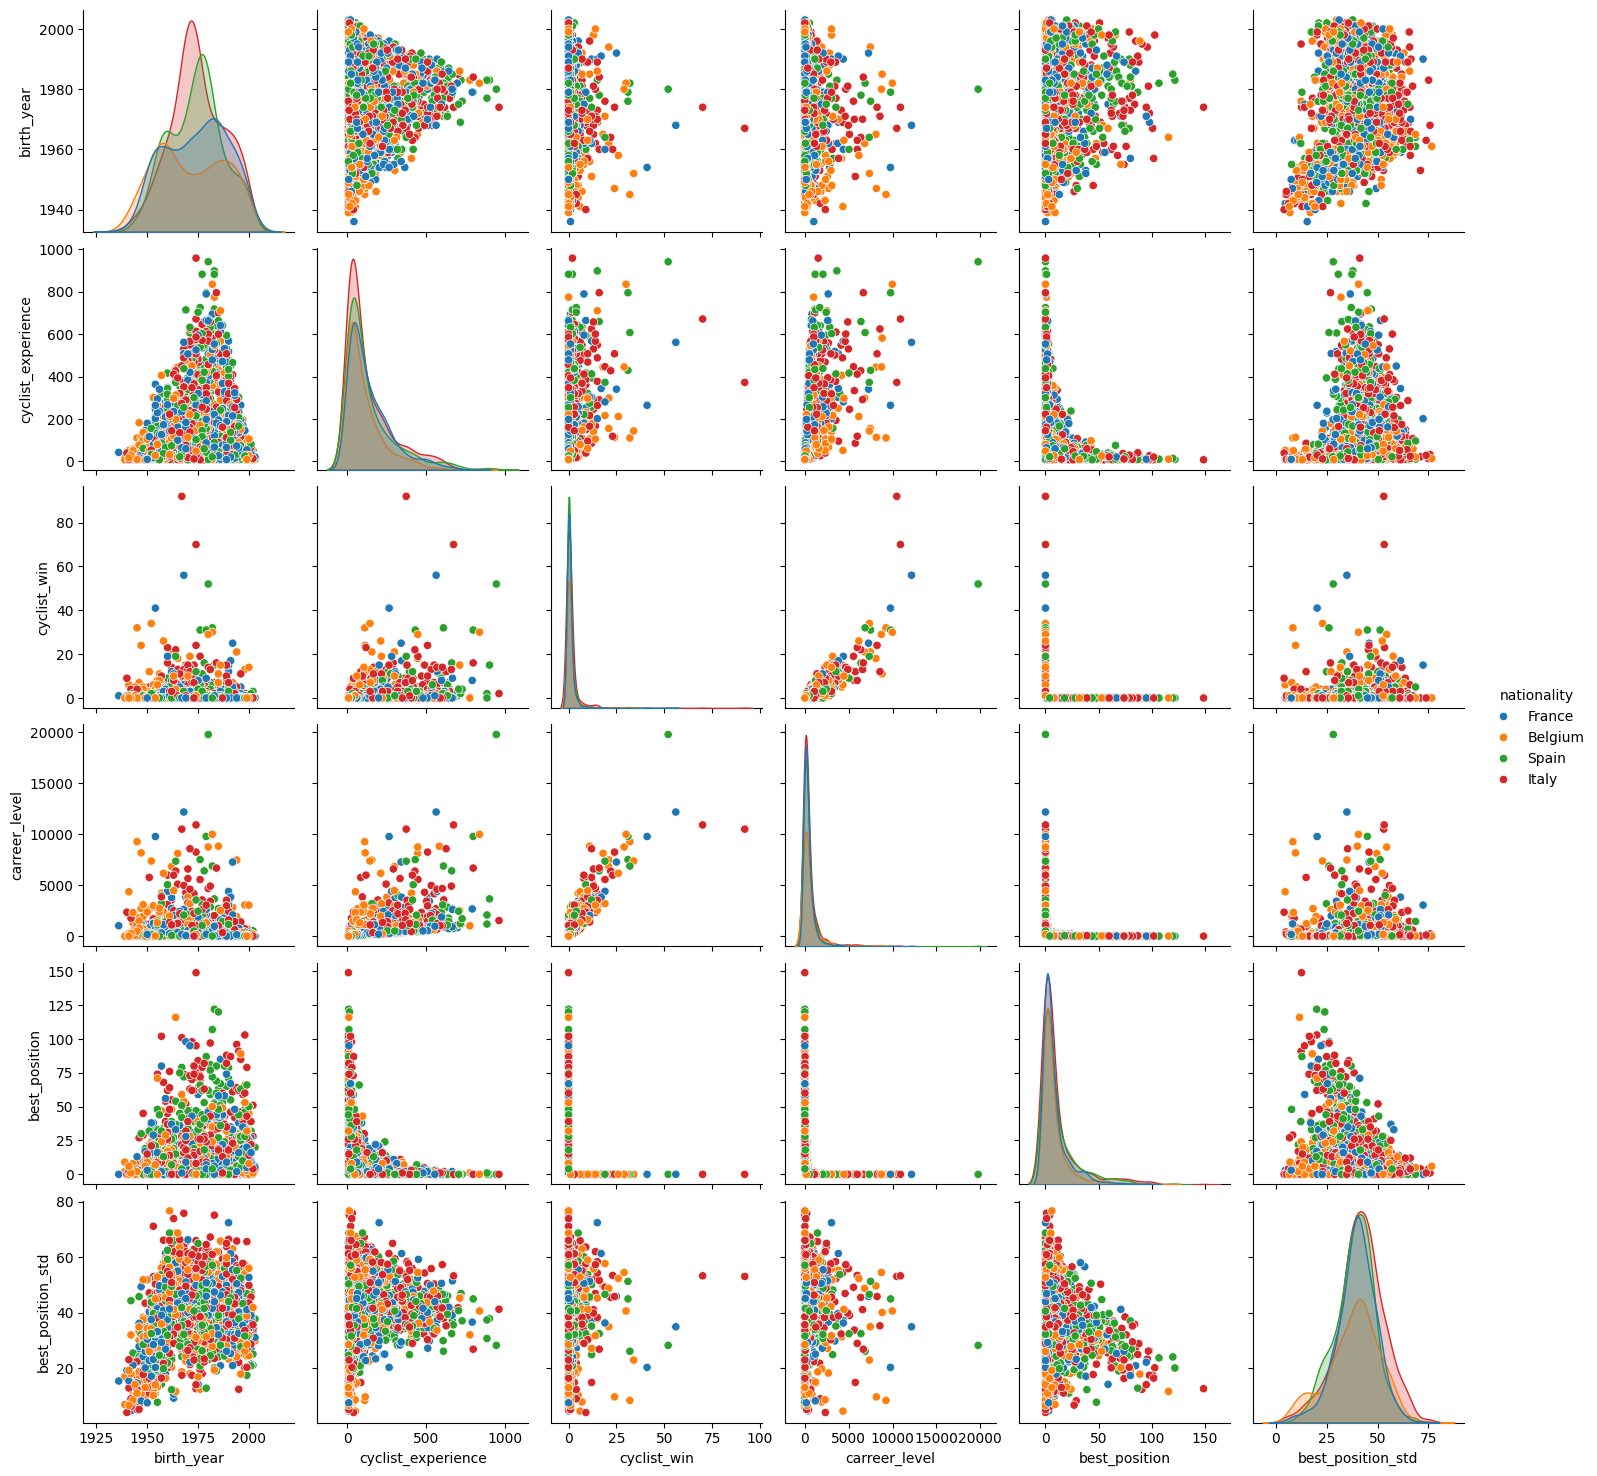

In [ ]:
# Filter cyclists by specified nationalities
filtered_cyclists_df = cyclists_df[cyclists_df['nationality'].isin(['Italy', 'Spain', 'Belgium', 'France'])]

sns.pairplot(filtered_cyclists_df, hue='nationality')
plt.show()

#### Correlation Analysis

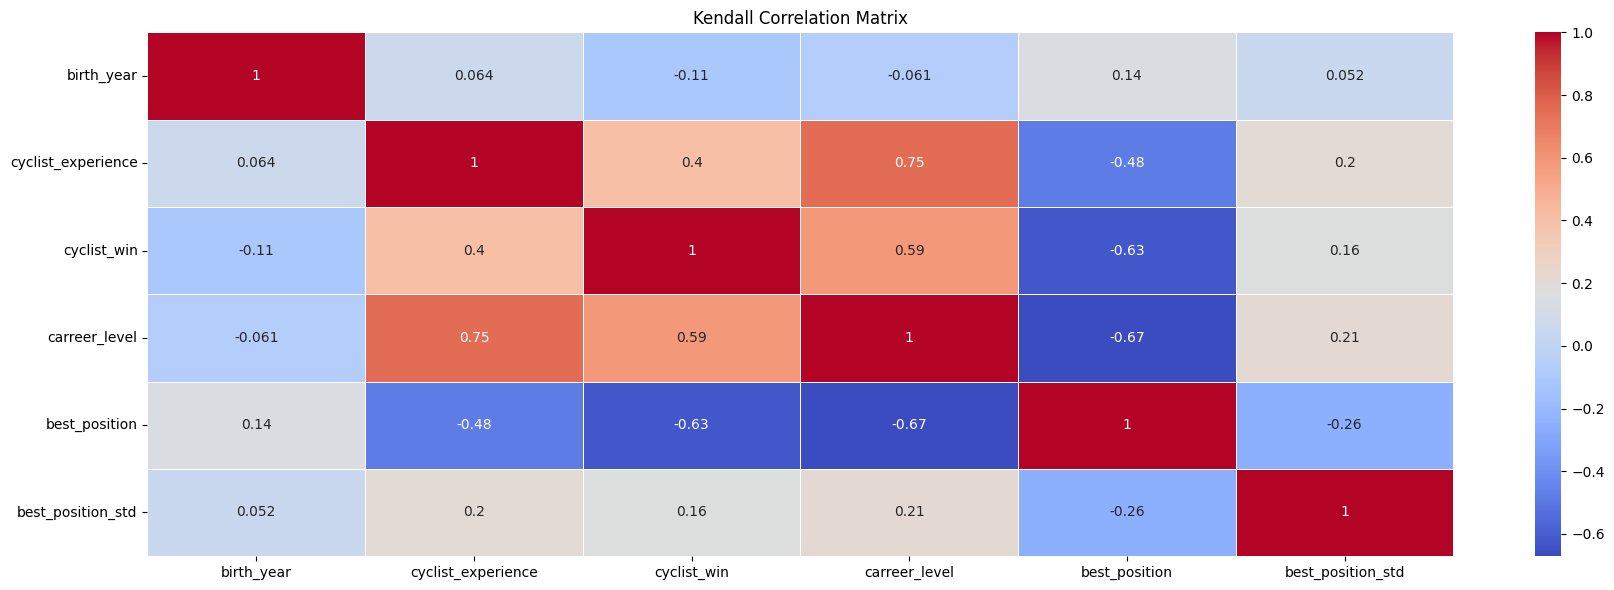

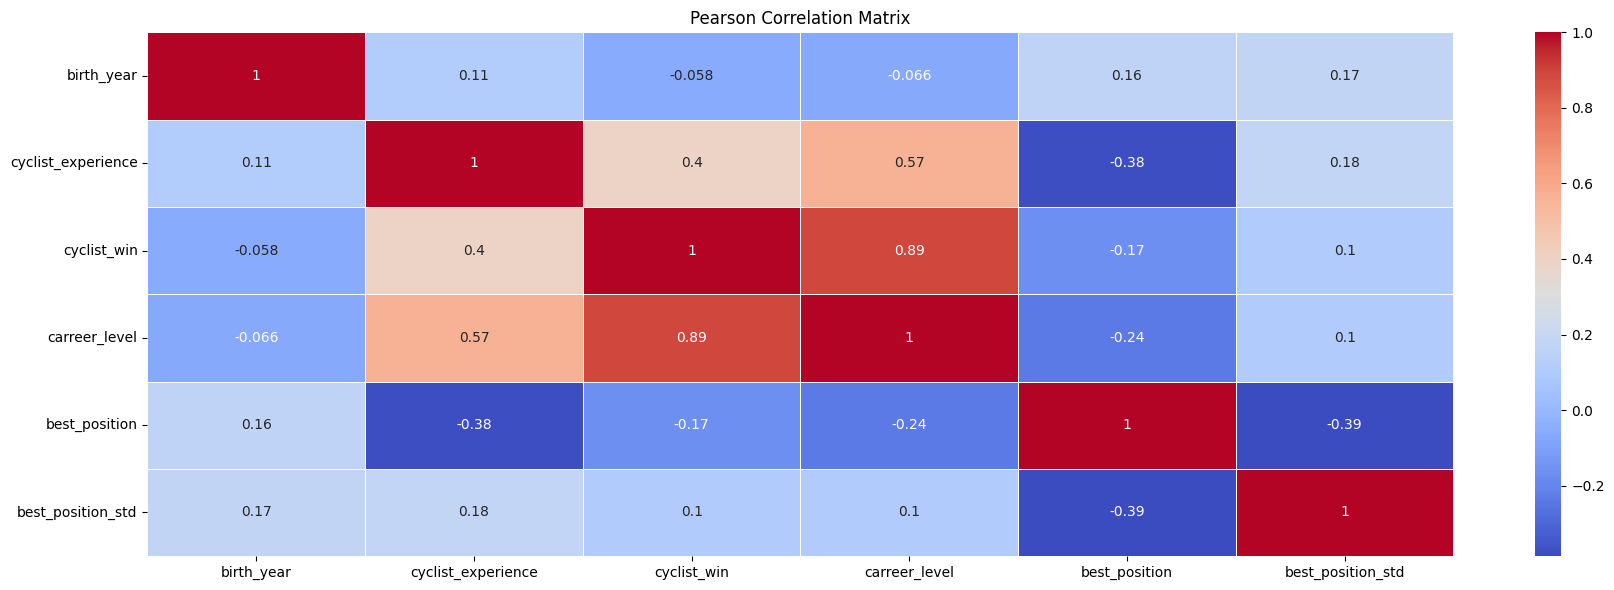

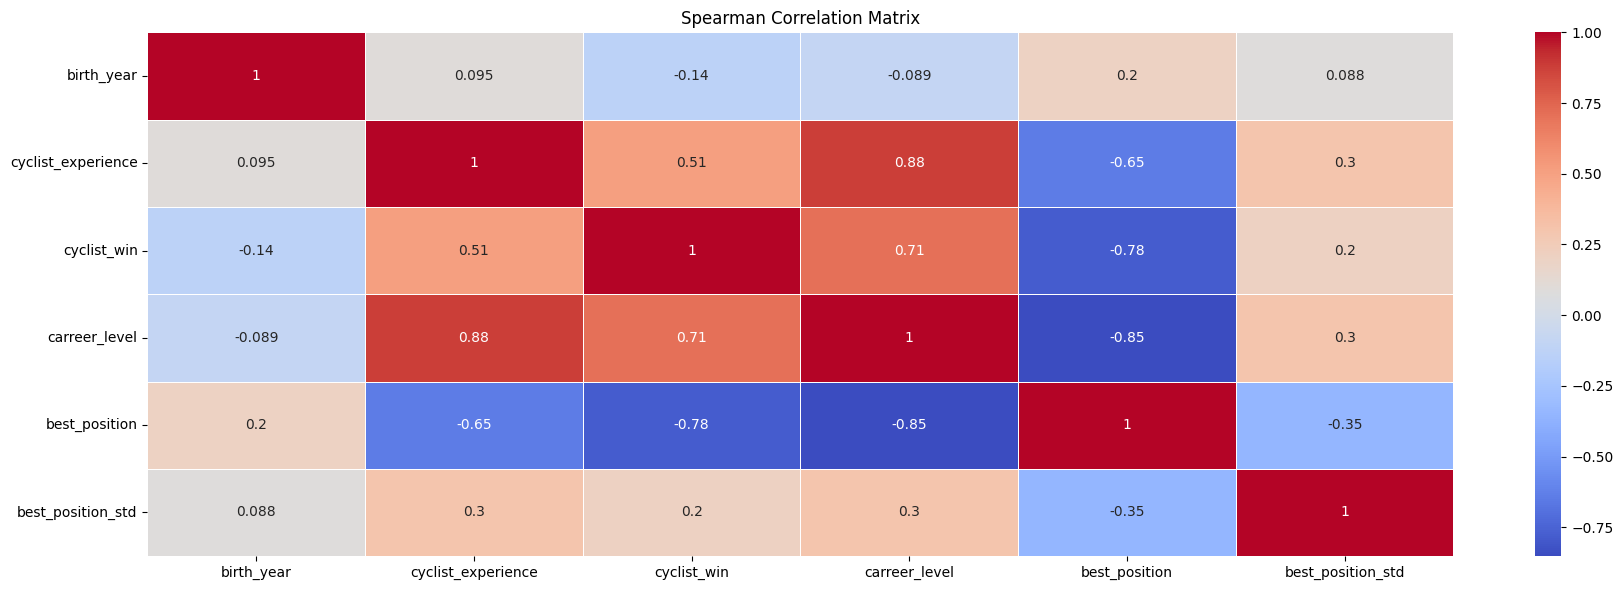

In [ ]:
from utils import center_and_scale, correlations, plot_correlations

normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_df)
cyclists_corr = correlations(normalized_cyclist, ["kendall"])
plot_correlations(cyclists_corr)
cyclists_corr = correlations(normalized_cyclist, ["pearson"])
plot_correlations(cyclists_corr)
cyclists_corr = correlations(normalized_cyclist, ["spearman"])
plot_correlations(cyclists_corr)

We decide to drop column with high correlation

In [ ]:
cyclists_df.drop(columns=['cyclist_experience'], inplace=True)

In [ ]:
cyclists_df.columns.to_list()

['_url',
 'name',
 'birth_year',
 'nationality',
 'experience_cat',
 'continent',
 'cyclist_win',
 'carreer_level',
 'best_position',
 'best_position_std']

In [ ]:
cyclists_df.to_csv('dataset/cyclists_clustering.csv', index=False)